<a href="https://colab.research.google.com/github/Itsuki-Hamano123/auto_ml/blob/master/auto-keras/colorectal_histology/autokeras_img_clf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install git+https://github.com/keras-team/keras-tuner.git@1.0.2rc1
%pip install autokeras
%pip show keras-tuner
%pip show autokeras
%pip show tensorflow

  Cloning https://github.com/keras-team/keras-tuner.git (to revision 1.0.2rc1) to /tmp/pip-req-build-ehqfltxw
  Running command git clone -q https://github.com/keras-team/keras-tuner.git /tmp/pip-req-build-ehqfltxw
  Running command git checkout -q 0fb69434a132093518e0e53d40020145ae192629
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2rc1-cp36-none-any.whl size=85424 sha256=1f348b56d9429219929eb7d61ceeb3b9637aa12e5dd278e23345a4bda411b1a8
  Stored in directory: /tmp/pip-ephem-wheel-cache-11hikvmg/wheels/af/c9/7c/6ea01f9753a5dd1484136b4cb7b33a0a7fba253e5c74ade5af
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15356 sha256=02ec0671780049ca3146e3b971939d8cae33b6df2d27a174a7282324af819389
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables
     |████████████████████████████████| 122kB 5.7MB/s 
Name: keras-tuner
Version: 1.0.2rc1
Summary: 

In [6]:
import tensorflow as tf
import tensorflow_datasets  as tfds
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

from autokeras import ImageClassifier

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## データの読み込み

In [3]:
def fetch_tf_dataset(data_name, 
                     split=['train[0%:60%]','train[60%:80%]','train[80%:100%]'],
                     shuffle_files=True, as_supervised=True,
                     with_info=True, batch_size=None):
  '''TensorFlowデータセットからデータをフェッチ'''
  (ds_train, ds_val, ds_test), data_info = tfds.load(data_name, split=split,
                                  shuffle_files=shuffle_files,
                                  as_supervised=as_supervised,
                                  with_info=with_info,
                                  batch_size=batch_size)
  return ds_train, ds_val, ds_test, data_info
  


data_name = 'colorectal_histology' # @param{type:'string'}
x_name = 'image' # @param{type:'string'}
y_name = 'label' # @param{type:'string'}
# インメモリでデータを読み込む
# autokerasのfit関数がdatasetV1Adapter,generatorを受け付けないため
batch_size = -1

# データのフェッチ
ds_train, ds_val, ds_test, ds_info = fetch_tf_dataset(data_name=data_name,
                                     as_supervised=False,
                                     batch_size=batch_size)

display(ds_info)


# numpy配列に変換
# autokerasのfit関数がtf.Tensorを受け付けないため
x_train = ds_train[x_name].numpy()
y_train = ds_train[y_name].numpy()
x_val = ds_val[x_name].numpy()
y_val = ds_val[y_name].numpy()
x_test = ds_test[x_name].numpy()
y_test = ds_test[y_name].numpy()

print('train x shape;{}'.format(x_train.shape))
print('val x shape;{}'.format(x_val.shape))
print('test x shape;{}'.format(x_test.shape))

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/colorectal_histology/2.0.0.incompleteKCA5O5/colorectal_histology-train.tfrecord


Dataset colorectal_histology downloaded and prepared to /root/tensorflow_datasets/colorectal_histology/2.0.0. Subsequent calls will reuse this data.


tfds.core.DatasetInfo(
    name='colorectal_histology',
    version=2.0.0,
    description='Classification of textures in colorectal cancer histology. Each example is a 150 x 150 x 3 RGB image of one of 8 classes.',
    homepage='https://zenodo.org/record/53169#.XGZemKwzbmG',
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(150, 150, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=8),
    }),
    total_num_examples=5000,
    splits={
        'train': 5000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{kather2016multi,
      title={Multi-class texture analysis in colorectal cancer histology},
      author={Kather, Jakob Nikolas and Weis, Cleo-Aron and Bianconi, Francesco and Melchers, Susanne M and Schad, Lothar R and Gaiser, Timo and Marx, Alexander and Z{"o}llner, Frank Gerrit},
      journal={Scientific reports},
      volume={6},
      pages={27988},
      y

train x shape;(3000, 150, 150, 3)
val x shape;(1000, 150, 150, 3)
test x shape;(1000, 150, 150, 3)


## Auto-Kerasでモデル作成

In [4]:
TASK_NAME = data_name + '_model'
CLASS_NUM = ds_info.features[y_name].num_classes
MAX_TRIALS = 15 #@param {type: "slider", min: 1, max: 50}
SEED = 7

print('クラス数:{}'.format(CLASS_NUM))
print('log dir:{}'.format(TASK_NAME))


clf = ImageClassifier(max_trials=MAX_TRIALS,
                      num_classes=CLASS_NUM, multi_label=False,
                      directory=TASK_NAME, overwrite=True,
                      seed=SEED)

クラス数:8
log dir:colorectal_histology_model


In [5]:
EPOCHS = 100 #@param {type: "slider", min: 1, max: 200}
es = EarlyStopping(patience=3)


clf.fit(x=x_train, y=y_train, epochs=EPOCHS,
        callbacks=[es], validation_data=(x_val, y_val),
        verbose=1)

Trial 15 Complete [00h 01m 39s]
val_loss: 2.9315152168273926

Best val_loss So Far: 0.17925724387168884
Total elapsed time: 02h 15m 18s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
normalization (Normalization (None, 150, 150, 3)       7         
_________________________________________________________________
random_translation (RandomTr (None, 150, 150, 3)       0         
_________________________________________________________________
random_flip (RandomFlip)     (None, 150, 150, 3)       0         
_________________________________________________________________
resizing (Resizing)          (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, None, None, 2048)  23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)             

None

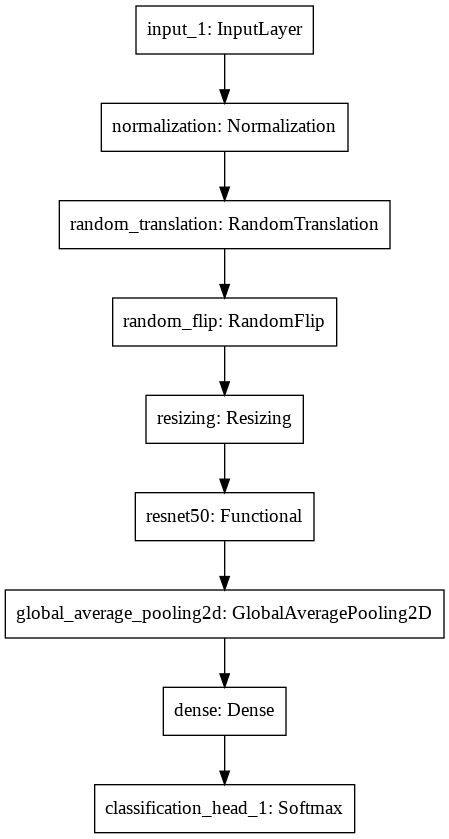

In [7]:
best_clf = clf.export_model()
display(best_clf.summary())
plot_model(best_clf)

In [8]:
def evalute_model(model, x, y_true):
  '''モデルの評価関数呼び出し'''
  score = model.evaluate(x=x, y=y_true)
  return score


train_score = evalute_model(clf, x_train, y_train)
val_score = evalute_model(clf, x_val, y_val)
test_score = evalute_model(clf, x_test, y_test)
print('訓練 loss:{loss}, 正答率:{auc}'.format(loss=train_score[0], auc=train_score[1]))
print('検証 loss:{loss}, 正答率:{auc}'.format(loss=val_score[0], auc=val_score[1]))
print('テスト loss:{loss}, 正答率:{auc}'.format(loss=test_score[0], auc=test_score[1]))

32/32 [==============================] - 3s 96ms/step - loss: 0.1291 - accuracy: 0.9690
訓練 loss:0.023572783917188644, 正答率:0.9913333058357239
検証 loss:0.17925724387168884, 正答率:0.9480000138282776
テスト loss:0.12908805906772614, 正答率:0.968999981880188


----- 訓練データ レポート-----


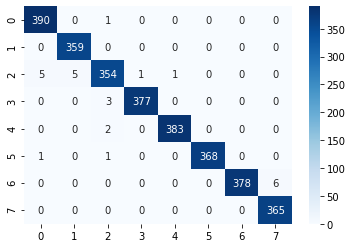

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       391
           1       0.99      1.00      0.99       359
           2       0.98      0.97      0.97       366
           3       1.00      0.99      0.99       380
           4       1.00      0.99      1.00       385
           5       1.00      0.99      1.00       370
           6       1.00      0.98      0.99       384
           7       0.98      1.00      0.99       365

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000

----------
----- 検証データ レポート-----


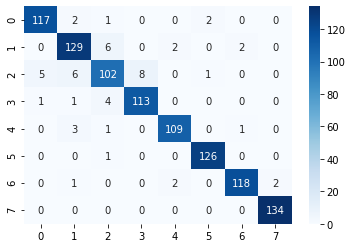

              precision    recall  f1-score   support

           0       0.95      0.96      0.96       122
           1       0.91      0.93      0.92       139
           2       0.89      0.84      0.86       122
           3       0.93      0.95      0.94       119
           4       0.96      0.96      0.96       114
           5       0.98      0.99      0.98       127
           6       0.98      0.96      0.97       123
           7       0.99      1.00      0.99       134

    accuracy                           0.95      1000
   macro avg       0.95      0.95      0.95      1000
weighted avg       0.95      0.95      0.95      1000

----------
----- テストデータ レポート-----


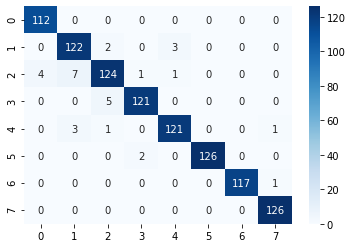

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       112
           1       0.92      0.96      0.94       127
           2       0.94      0.91      0.92       137
           3       0.98      0.96      0.97       126
           4       0.97      0.96      0.96       126
           5       1.00      0.98      0.99       128
           6       1.00      0.99      1.00       118
           7       0.98      1.00      0.99       126

    accuracy                           0.97      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000

----------


In [9]:
def _calc_sk_metric(sk_metric, y_true, y_pred):
  '''sklearnの評価関数を使う'''
  result = sk_metric(y_true, y_pred)
  return result


def print_sk_metrics(sk_metrics, y_true, y_pred, data_name=None):
  '''sklearnの評価指標の計算結果を画面に出力'''
  print('----- {} レポート-----'.format(data_name))
  for sk_metric in sk_metrics:
    report = _calc_sk_metric(sk_metric, y_true, y_pred)
    
    if(sk_metric.__name__ == 'confusion_matrix'):
      plt.show(sns.heatmap(report, annot=True, fmt='d', cmap='Blues'))
    else:
      print(report)

  print('----------')


use_sk_metrics = [confusion_matrix, classification_report]


# 訓練データに対する評価
y_train_pred = clf.predict(x_train)
print_sk_metrics(sk_metrics=use_sk_metrics, y_true=y_train,
                 y_pred=y_train_pred, data_name='訓練データ')

# 検証データに対する評価
y_val_pred = clf.predict(x_val)
print_sk_metrics(sk_metrics=use_sk_metrics, y_true=y_val,
                 y_pred=y_val_pred, data_name='検証データ')

# テストデータに対する評価
y_test_pred = clf.predict(x_test)
print_sk_metrics(sk_metrics=use_sk_metrics, y_true=y_test,
                 y_pred=y_test_pred, data_name='テストデータ')